In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/HD dacon2")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/HD dacon2'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

%matplotlib inline
plt.style.use(['dark_background'])
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [3]:
# 각 컬럼의 의미 확인용으로 출력
info = pd.read_excel('data_info.xlsx')

In [4]:
# 데이터 불러오기
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [ ]:
# 컬럼명 소개
for column in train.columns:
    for i in range(len(info)):
      if column == info.at[i, 'Feature Name']:
        print(info. at[i, 'Feature Name'], '==' ,info.at[i, 'Description'])

ARI_CO == 도착항의 소속국가(도착항 앞 2글자)
ARI_PO == 도착항의 항구명(도착항 뒤 글자)
SHIP_TYPE_CATEGORY == 선종 통합 바탕으로 5대 선종으로 분류
DIST == 정박지(ber_port)와 접안지 사이의 거리
ATA == anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)
ID == 선박식별 일련번호
BREADTH == 선박의 폭
BUILT == 선박의 연령
DEADWEIGHT == 선박의 재화중량톤수
DEPTH == 선박의 깊이
DRAUGHT == 흘수 높이
GT == 용적톤수(Gross Tonnage)값
LENGTH == 선박의 길이
SHIPMANAGER == 선박 소유주
FLAG == 선박의 국적
U_WIND == 풍향 u벡터
V_WIND == 풍향 v벡터
AIR_TEMPERATURE == 기온
BN == 보퍼트 풍력 계급
ATA_LT == anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)
PORT_SIZE == 접안지 폴리곤 영역의 크기
CI_HOUR == 대기시간


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [ ]:
train.describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939.000000,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,19.328187,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,30.930059,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,0.000000,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,0.000000,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,6.929678,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,25.692827,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,199.980651,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556


## 결측치 처리
### 1. 결측치 절반 이상인 컬럼 존재
#### 내 생각: 컬럼을 삭제하는 게 맞아보임.
### 2, 결측치가 존재하는 행 1개에 대한 처리
#### 내 생각:  평균으로 대체하거나, 가장 비슷한 데이터의 값을 그대로 쓰는 방법 가능(대체), 하지만 결측치를 가진 행 자체를 삭제하는 게 맞아보임.


In [ ]:
# 데이터프레임 전체 결측치 파악
total_missing = train.isna().sum()
print(total_missing)

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64


In [ ]:
# 딱 1개의 데이터
rows_with_missing_depth = train[train['DEPTH'].isnull()]

print(rows_with_missing_depth)

       ARI_CO ARI_PO SHIP_TYPE_CATEGORY  DIST              ATA       ID  \
356484     TW   JWI3              Cargo   0.0  2022-11-08 4:10  A457875   

        BREADTH  BUILT  DEADWEIGHT  DEPTH  DRAUGHT   GT  LENGTH SHIPMANAGER  \
356484      NaN     28        1500    NaN      NaN  500     NaN      GVPJ58   

         FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  PORT_SIZE  \
356484  Japan   -0.34   -1.91             25.3  1.752807      12    0.00099   

        CI_HOUR  
356484      0.0  


In [ ]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,10.0,10.0,4820,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,10.0,10.0,1600,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,20.0,10.0,34800,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,10.0,10.0,16900,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


In [ ]:
# DEPTH 컬럼에 결측치가 있는 행 삭제
train = train.dropna(subset=['DEPTH'])

In [ ]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,10.0,10.0,4820,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,10.0,10.0,1600,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,20.0,10.0,34800,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,10.0,10.0,16900,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


In [ ]:
'''from sklearn.impute import KNNImputer

### 결측치 KNNImputer를 통해 대체

# K-NN 대체기
knn_imputer = KNNImputer(n_neighbors=5)

# 결측치를 대체
train['BREADTH'] = knn_imputer.fit_transform(train[['BREADTH']])
train['DRAUGHT'] = knn_imputer.fit_transform(train[['DRAUGHT']])
train['DEPTH'] = knn_imputer.fit_transform(train[['DEPTH']])
train['LENGTH'] = knn_imputer.fit_transform(train[['LENGTH']])'''

## 상관관계
### DRAUGHT, DEPTH, DEADWEIGHT, BREADTH, GT 배가 크면 당연히 클 수밖에 없는 요소들
### 유가 데이터가 다 빠지니까 그냥 상관 관계 높은 게 배 크기가 크면 당연히 높을 수 밖에 없는 특성들만 나왔네..?

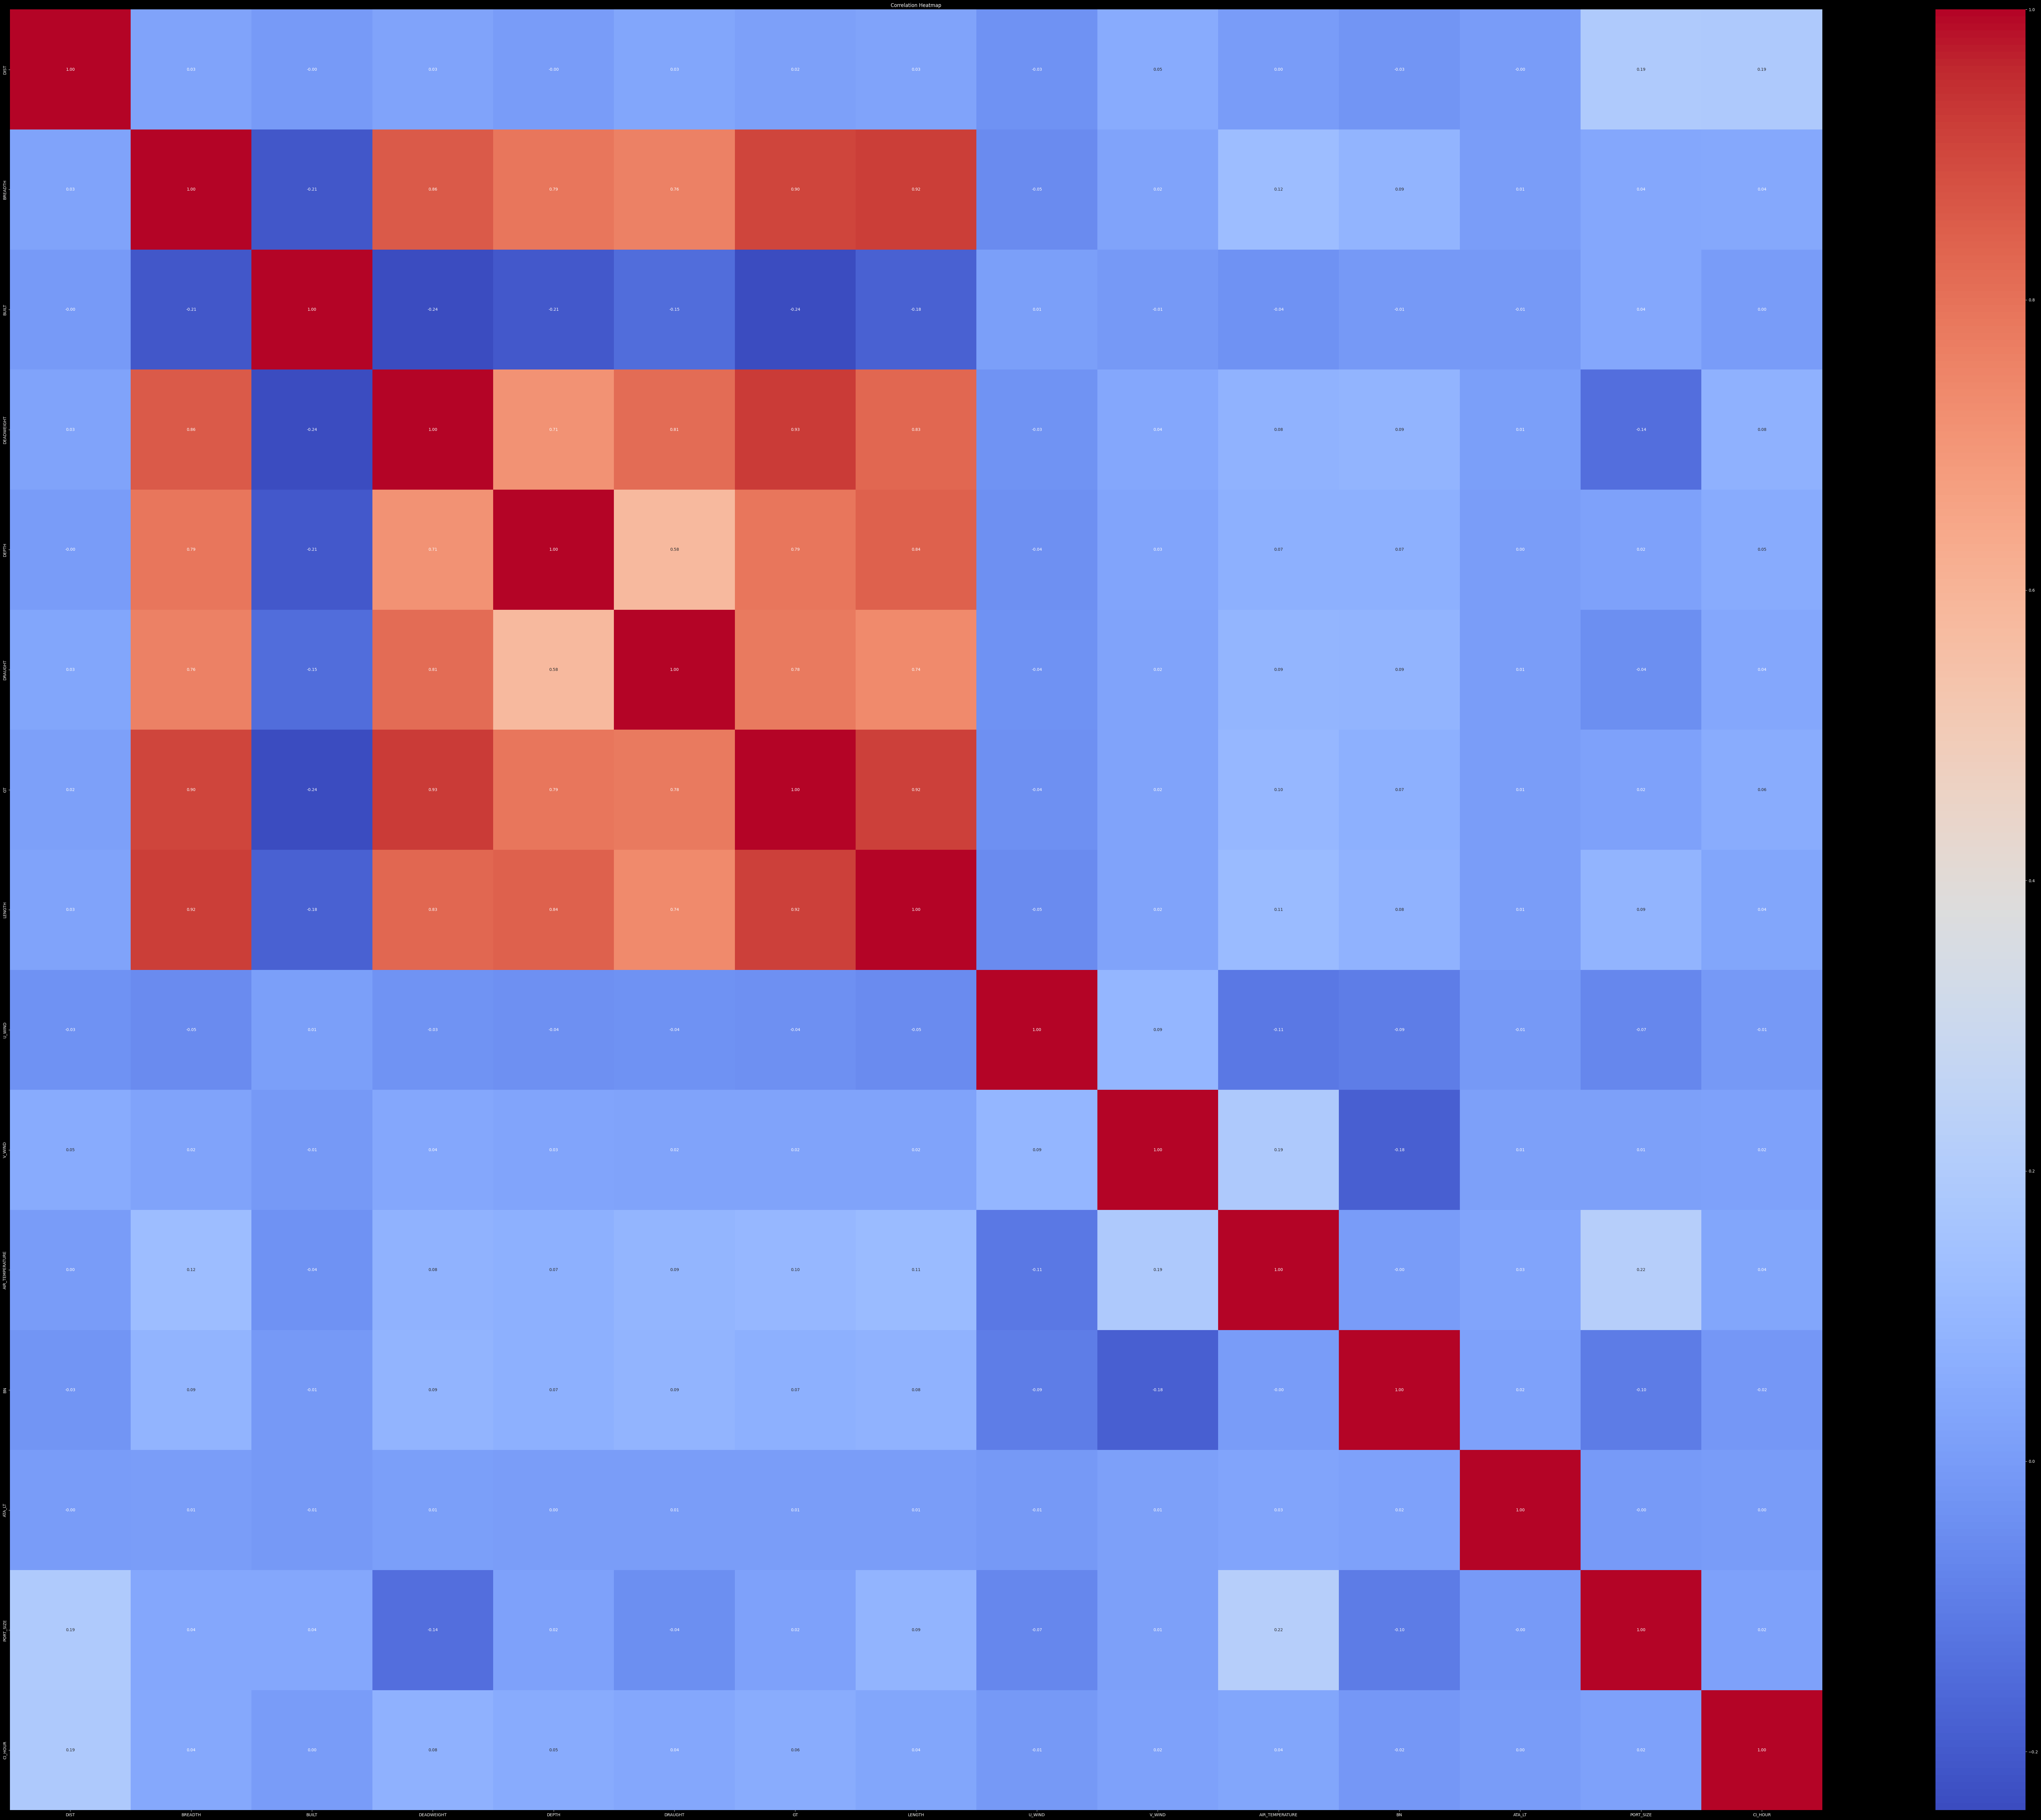

In [ ]:
# 상관관계 계산
correlation_matrix = train.corr()

# Heatmap 그리기
plt.figure(figsize=(100, 80))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# 상관 관계가 0.7 이상인 컬럼 쌍과 상관 행렬 값을 출력

high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= 0.7:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

for pair in high_correlation_pairs:
    print(f"{pair[0]} ---- {pair[1]}: {pair[2]}")

DEADWEIGHT ---- BREADTH: 0.8571256498329598
DEPTH ---- BREADTH: 0.7904762563477176
DEPTH ---- DEADWEIGHT: 0.7129690292516006
DRAUGHT ---- BREADTH: 0.7613225168082254
DRAUGHT ---- DEADWEIGHT: 0.8134011159867346
GT ---- BREADTH: 0.9039836410168791
GT ---- DEADWEIGHT: 0.9251433431219455
GT ---- DEPTH: 0.787595259427138
GT ---- DRAUGHT: 0.77902758972954
LENGTH ---- BREADTH: 0.9206521930150651
LENGTH ---- DEADWEIGHT: 0.8267656929867577
LENGTH ---- DEPTH: 0.8426380653220088
LENGTH ---- DRAUGHT: 0.7376058093671107
LENGTH ---- GT: 0.9166839430899801


## ATA 컬럼 위주 분석

In [ ]:
train['ATA'] = pd.to_datetime(train['ATA'])
df_ATAdate = train.copy()

df_ATAdate.drop(columns = 'U_WIND', inplace = True)
df_ATAdate.drop(columns = 'V_WIND', inplace = True)
df_ATAdate.drop(columns = 'AIR_TEMPERATURE', inplace = True)
df_ATAdate.drop(columns = 'BN', inplace = True)
df_ATAdate['ATA'] = df_ATAdate['ATA'].dt.floor('D')
#df_ATAdate['ATA'].head()

In [ ]:
df_ATAdate.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

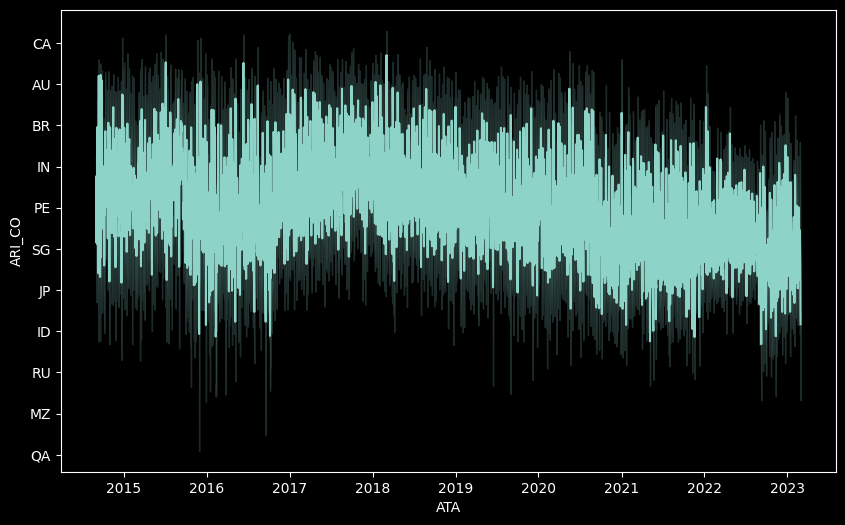

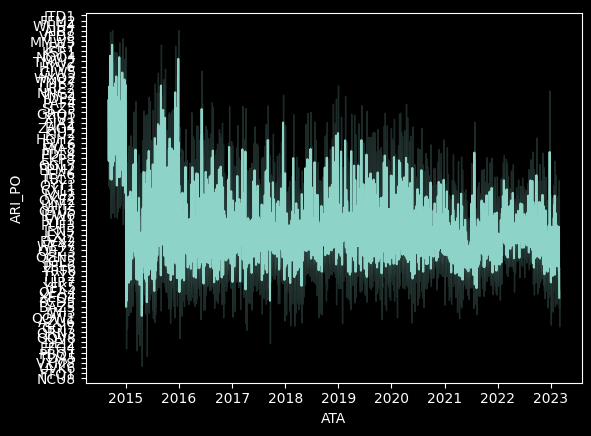

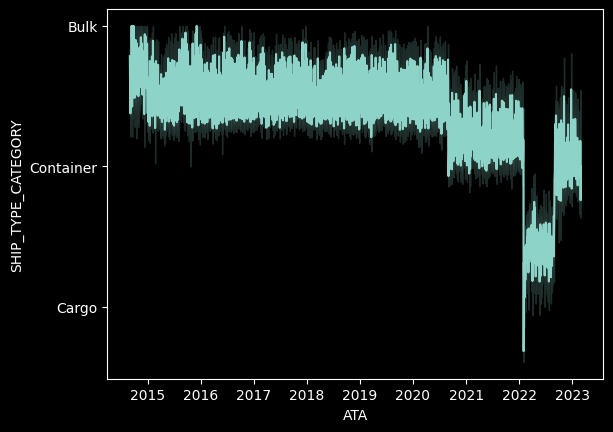

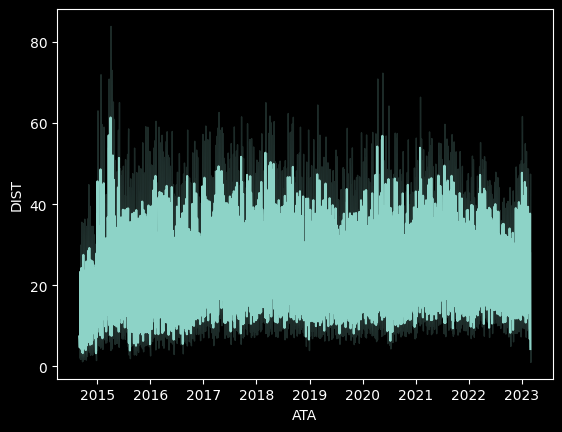

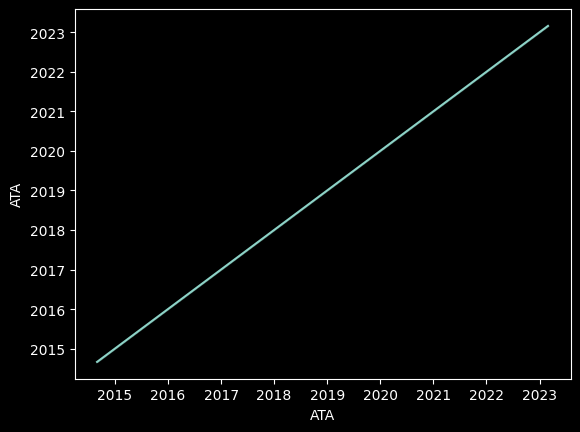

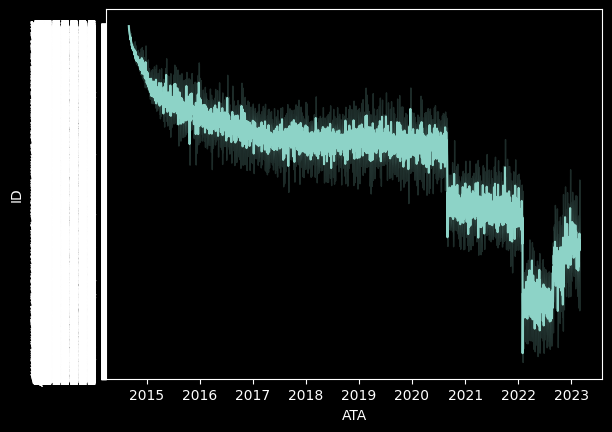

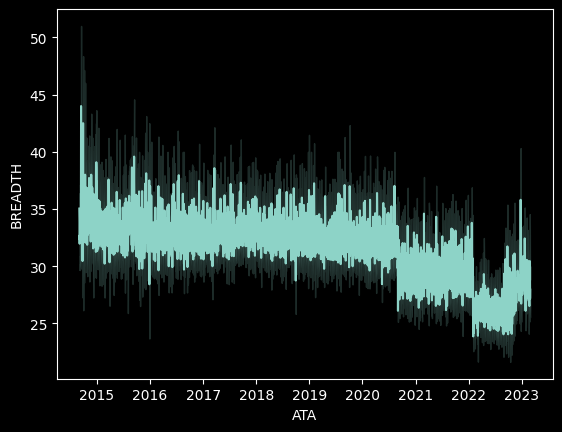

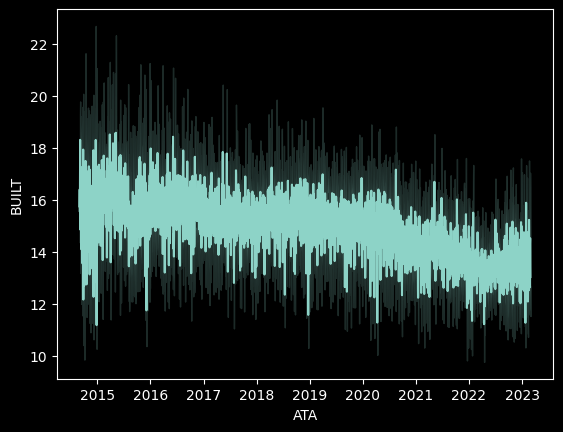

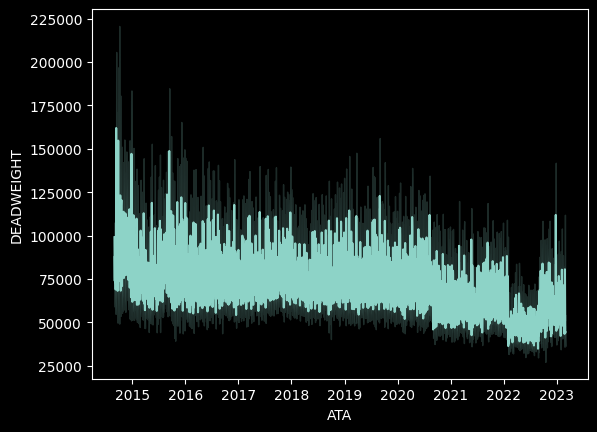

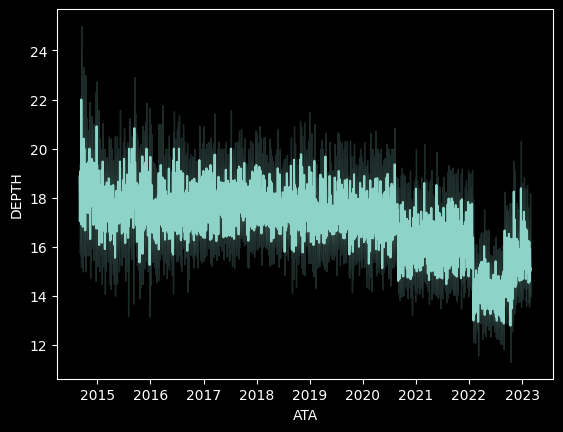

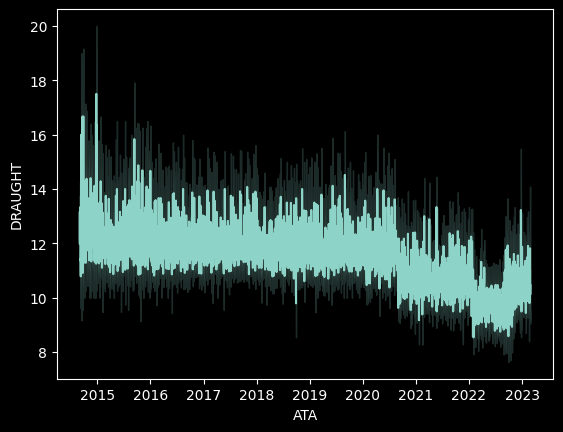

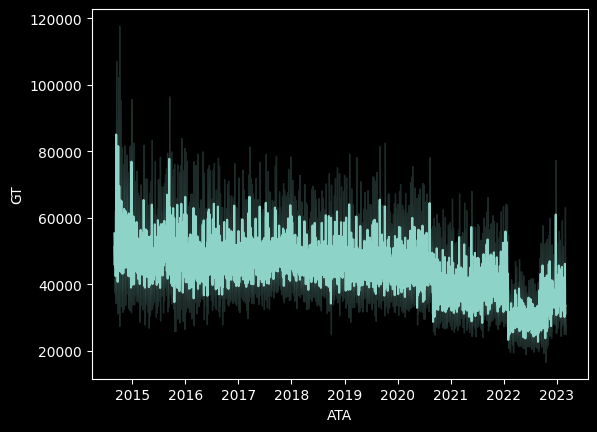

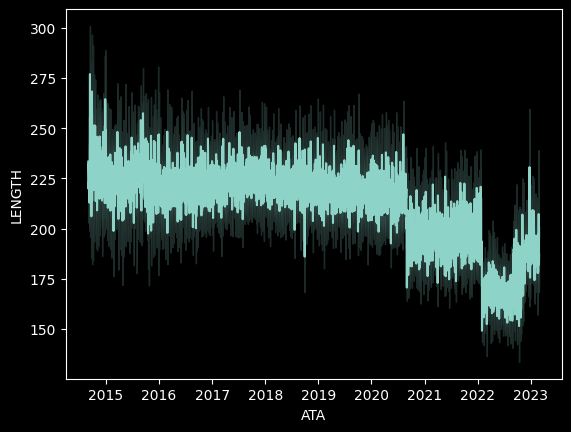

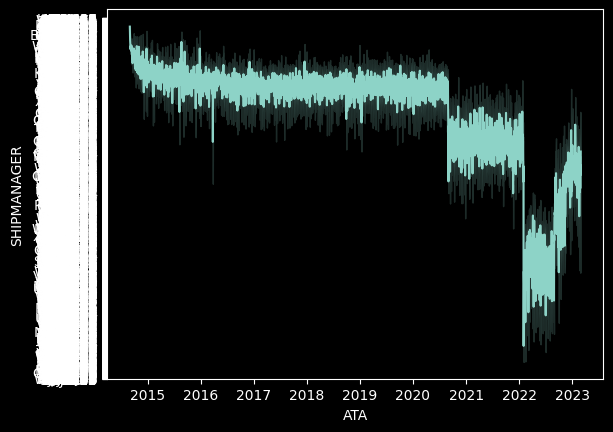

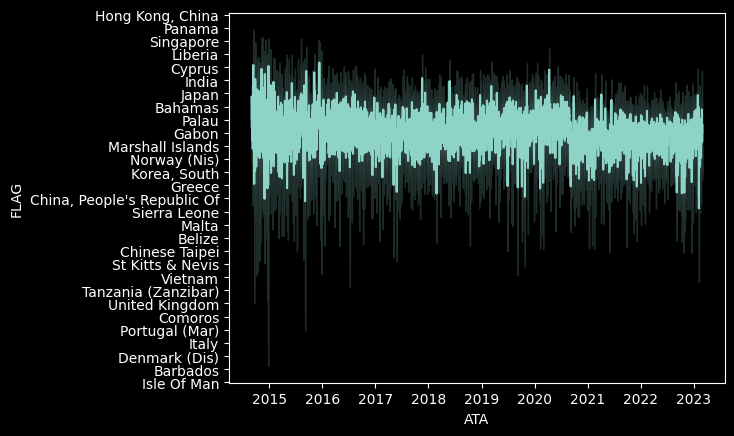

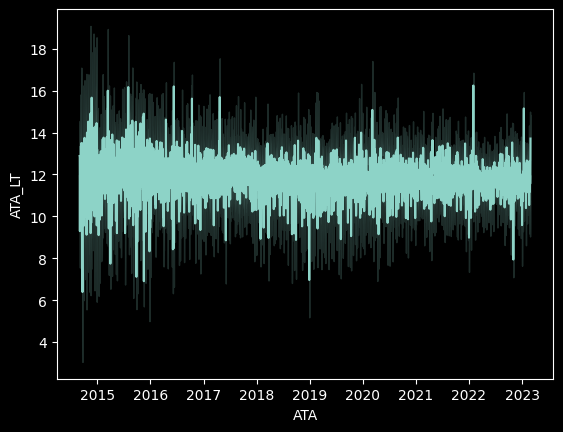

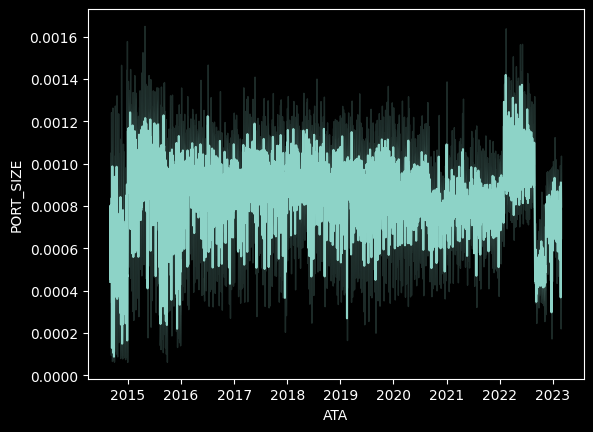

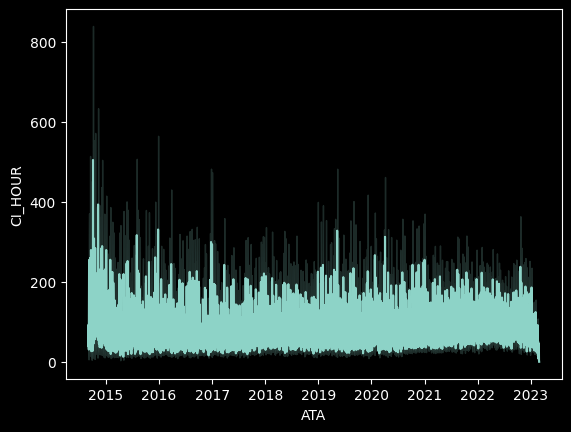

In [ ]:
plt.figure(figsize=(10, 6))

for column in df_ATAdate.columns:
    sns.lineplot(data = df_ATAdate.sort_values(by = 'ATA'), x = 'ATA', y = column)
    plt.show()

## year, month, day, hour, munute, weekday에 따른 boxplot

In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

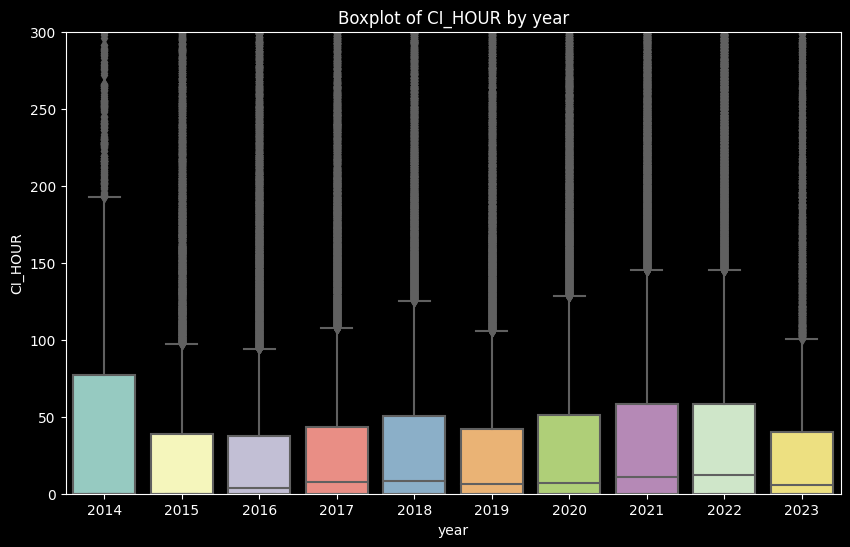

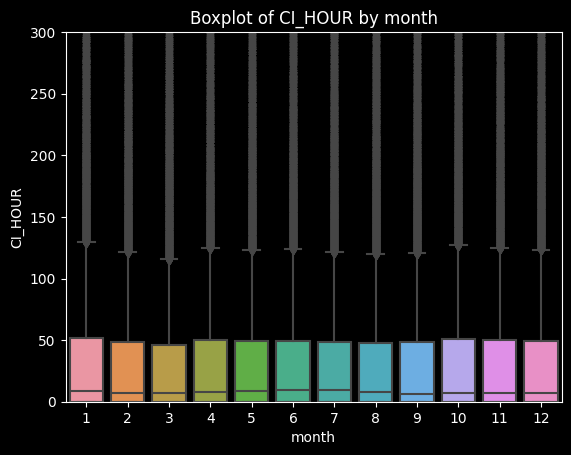

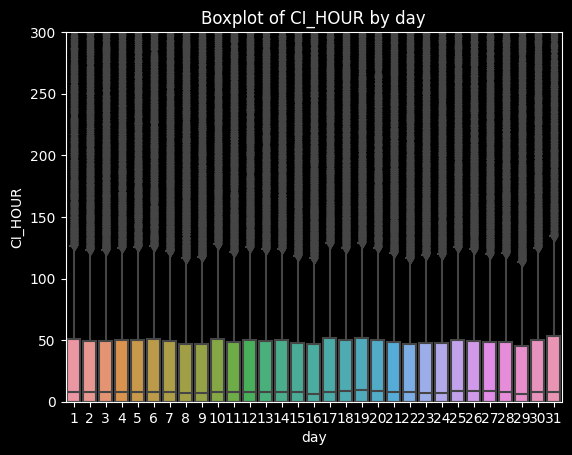

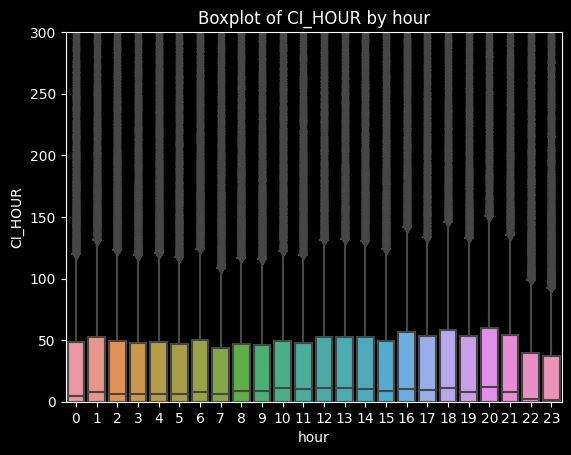

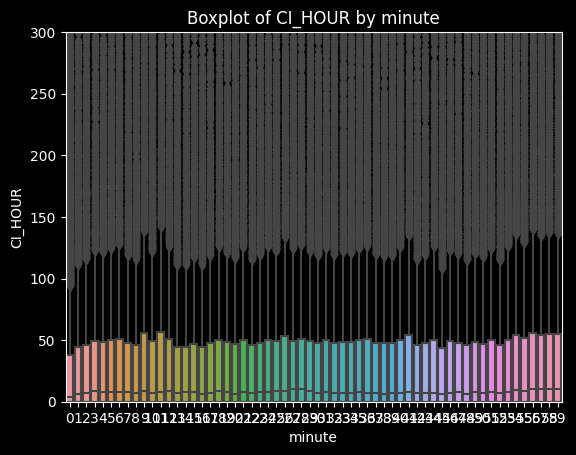

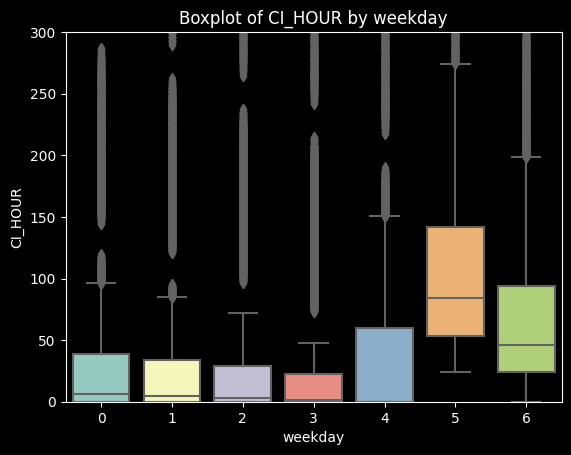

In [ ]:
plt.figure(figsize=(10, 6))

times = ['year', 'month', 'day', 'hour', 'minute', 'weekday']

for column in times:
    sns.boxplot(x=column, y='CI_HOUR', data=train)
    plt.xlabel(column)
    plt.ylabel('CI_HOUR')
    plt.title('Boxplot of CI_HOUR by ' + column)
    plt.ylim(0, 300)
    plt.show()

# DIST 컬럼 위주 분석
## 가정: DIST가 0이면 정박지와 접안지 사이의 거리가 0인 것이기 때문에 CI_HOUR가 0일 것이다.
## 전체 15만개 중에서 28개 제외 DIST가 0이면 CI_HOUR가 0이다.
## 내 생각: 0이 아닌 것은 noise나 human error가 판단해야 할 거 같음. 그러므로 0이 아닌 것들을 0으로 대체하는 게 맞아보임.

In [ ]:
result = train[train['DIST'] == 0]['CI_HOUR']
print(result)

1         0.0
2         0.0
3         0.0
7         0.0
8         0.0
         ... 
391924    0.0
391925    0.0
391926    0.0
391934    0.0
391938    0.0
Name: CI_HOUR, Length: 157293, dtype: float64


In [ ]:
# DIST가 0인 행만 필터링합니다.
dist_0_data = train[train['DIST'] == 0]

# CI_HOUR 컬럼의 값과 그 구성을 확인합니다.
counts = dist_0_data['CI_HOUR'].value_counts()

print(counts)

0.000000      157265
0.050000           2
8.650278           1
755.989444         1
25.999167          1
8.248333           1
0.568611           1
7.299167           1
1.201667           1
0.099167           1
62.012778          1
0.751389           1
95.951667          1
11.499722          1
158.303333         1
280.732778         1
57.998889          1
5.050000           1
191.500278         1
21.300556          1
1.748889           1
388.824444         1
634.015278         1
10.000000          1
0.049167           1
0.551389           1
0.748611           1
143.203889         1
Name: CI_HOUR, dtype: int64


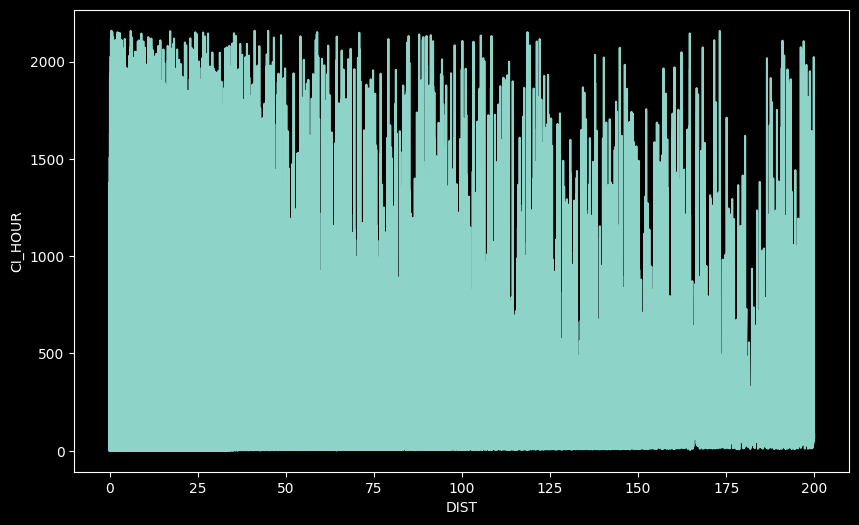

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(data = train.sort_values(by = 'DIST'), x = 'DIST', y = 'CI_HOUR')
plt.show()

# 배 크기 관련 *컬럼* 분석

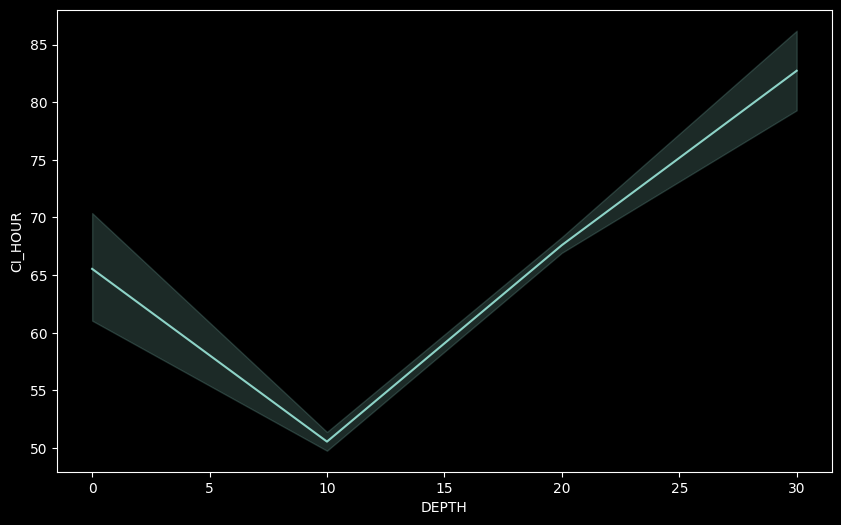

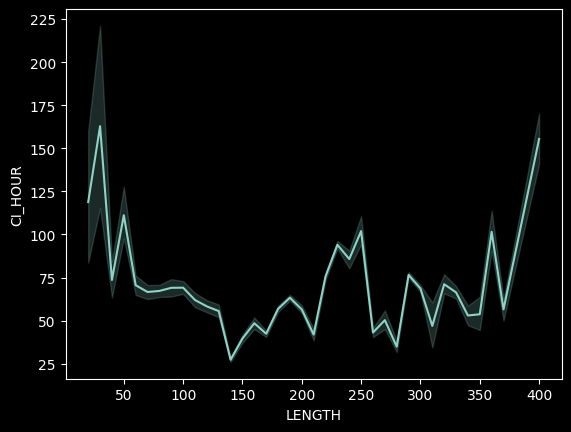

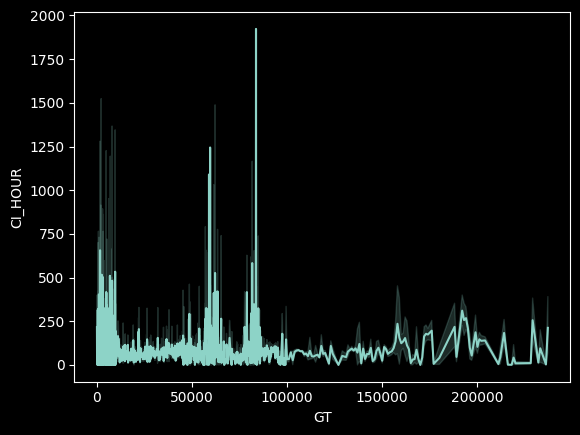

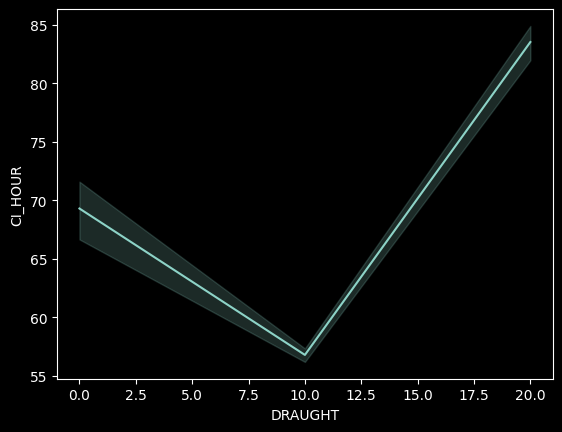

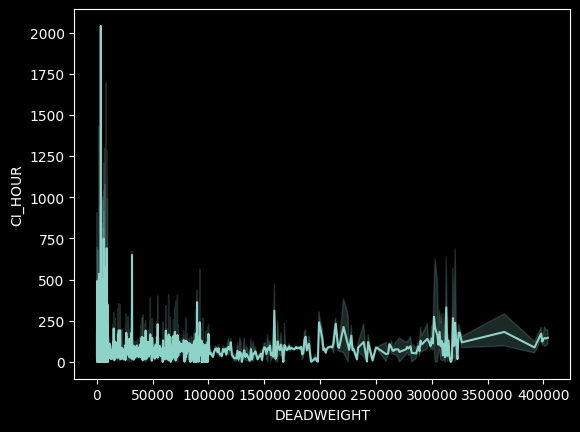

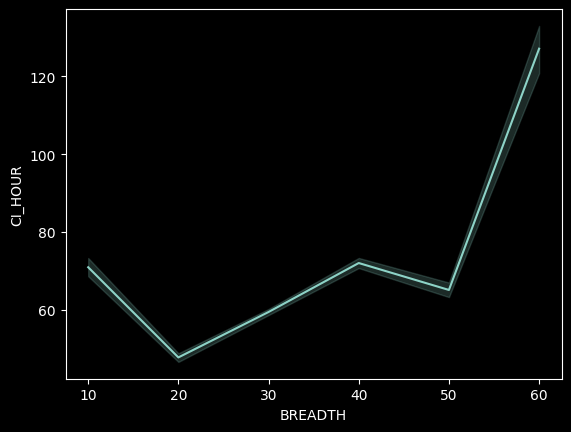

In [ ]:
plt.figure(figsize=(10, 6))

columns = ['DEPTH', 'LENGTH', 'GT', 'DRAUGHT', 'DEADWEIGHT', 'BREADTH']

for column in columns:
    sns.lineplot(data = train.sort_values(by = column), x = column, y = 'CI_HOUR')
    plt.show()

# Distplot 보기
## Dist, Built도 추가로 이상치 판단되는 부분 날리기

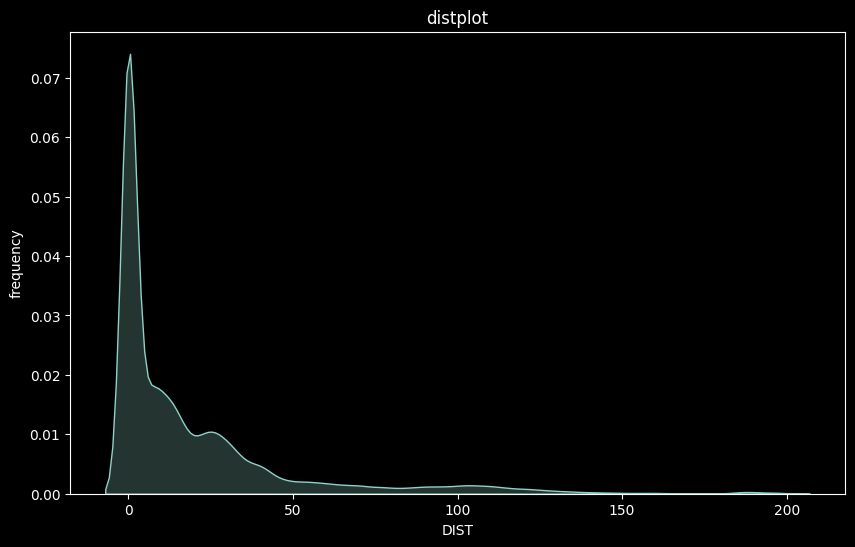

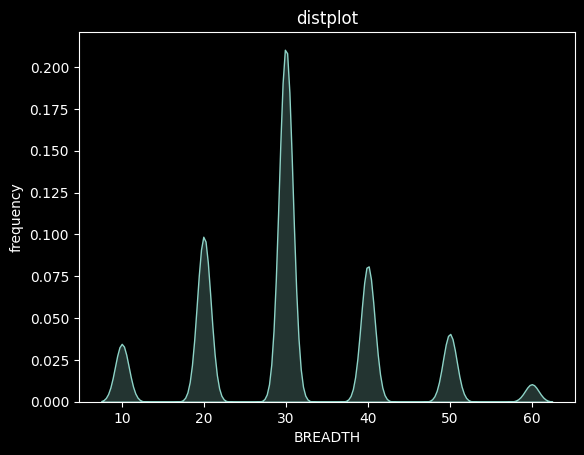

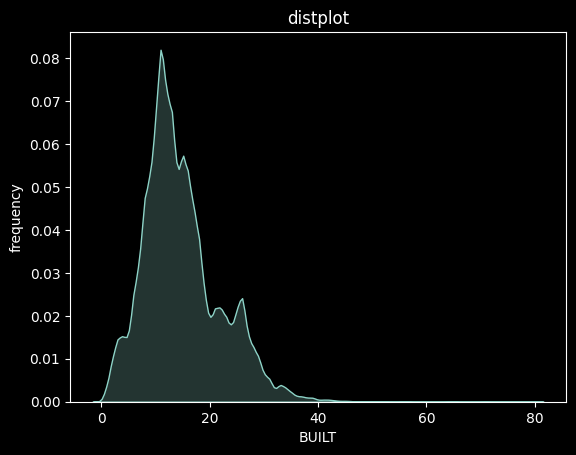

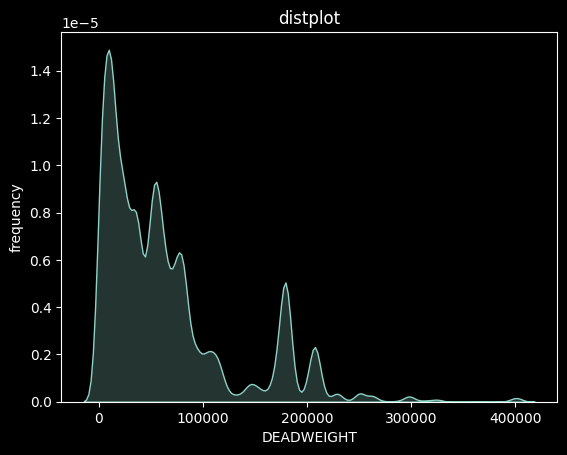

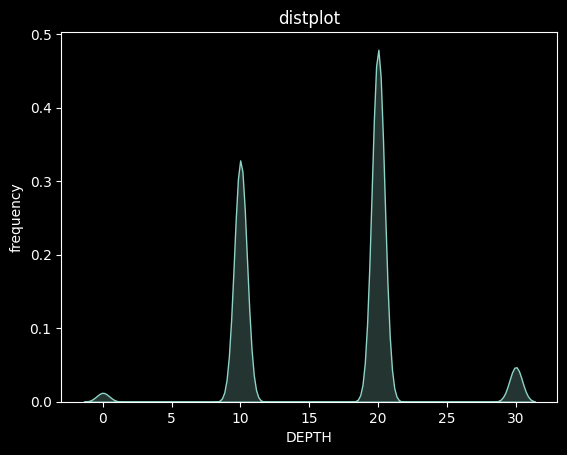

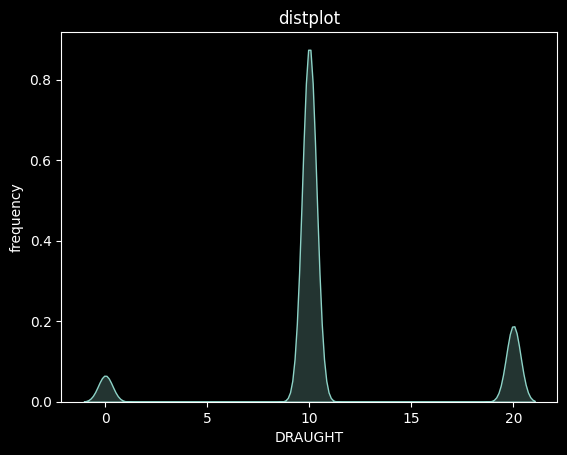

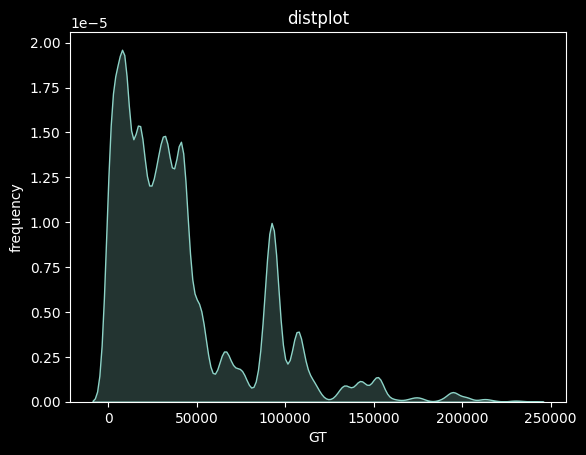

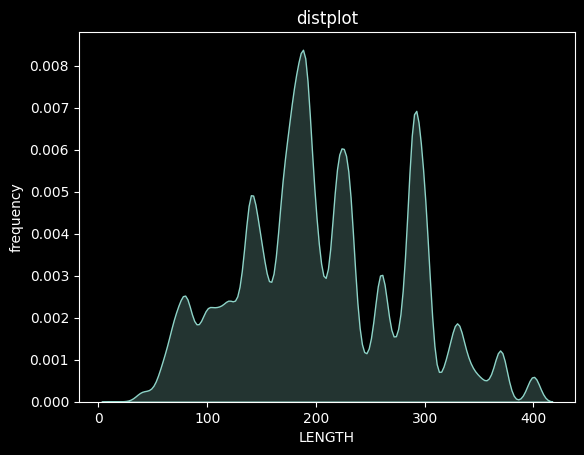

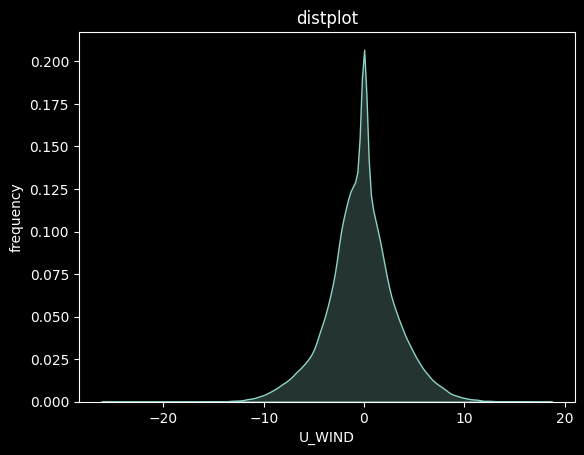

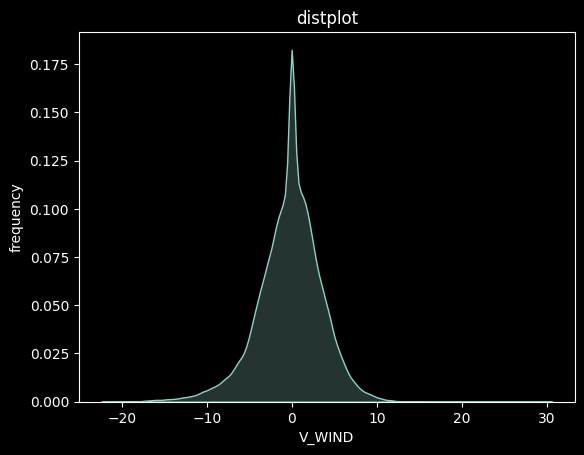

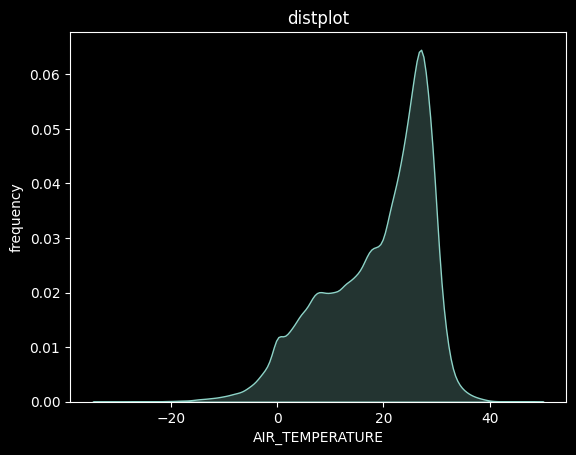

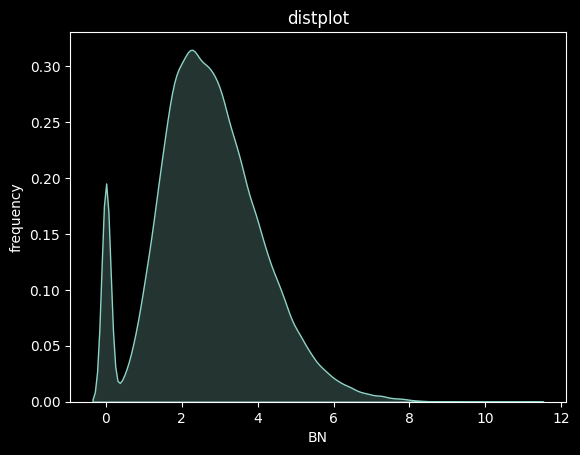

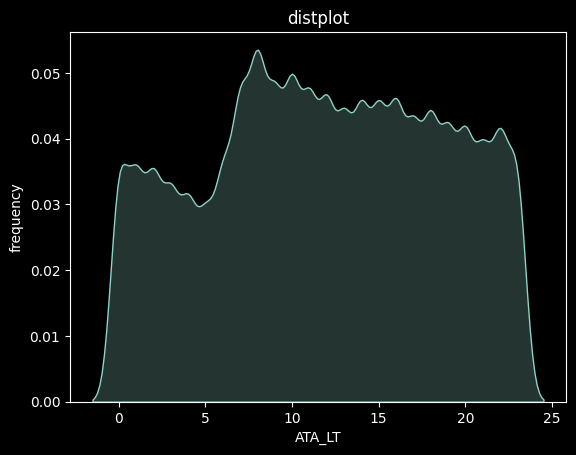

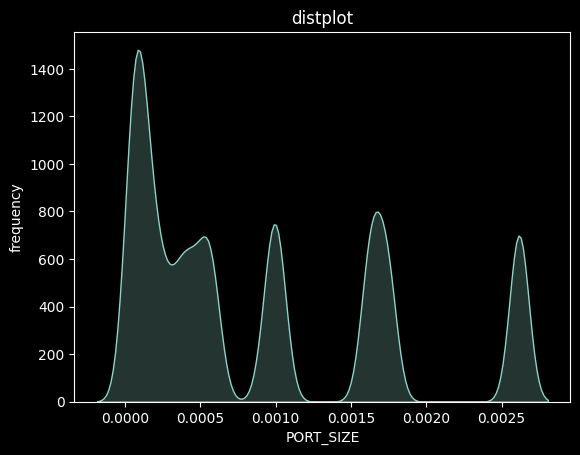

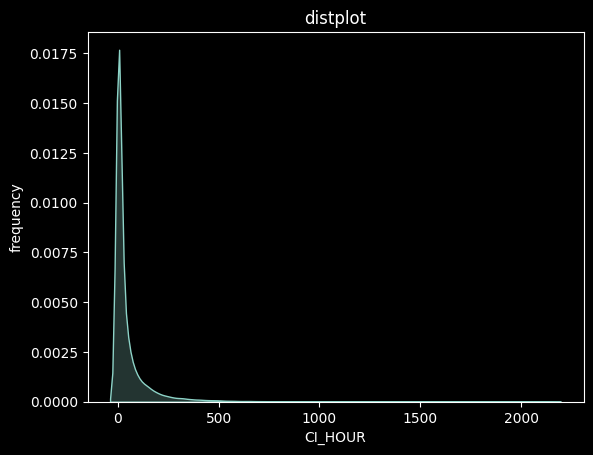

In [ ]:
columns = ['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'CI_HOUR']

plt.figure(figsize=(10, 6), dpi=100)  # 크기와 해상도 설정

# 밀도 그림 그리기
for column in columns:
    sns.kdeplot(train[column], shade=True)  # 밀도 그림 그리기
    plt.title('distplot')  # 그래프 제목 설정
    plt.xlabel(column)  # x축 레이블 설정
    plt.ylabel('frequency')  # y축 레이블 설정
    plt.show()  # 그래프 표시

In [ ]:
remove_columns = ['DIST', 'BUILT']

# 'CI_HOUR' 열의 평균과 표준 편차 계산
for column in remove_columns:
    mean = train[column].mean()
    std = train[column].std()

# 이상치 경계 설정 (예: 평균에서 2배 표준 편차를 벗어나는 값)
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

In [ ]:
# 이상치 갯수
print(train[train['DIST'] < lower_bound].shape)
print(train[train['DIST'] > upper_bound].shape)

(0, 22)
(64702, 22)


In [ ]:
# 이상치 갯수
print(train[train['BUILT'] < lower_bound].shape)
print(train[train['BUILT'] > upper_bound].shape)

(0, 22)
(2816, 22)


# SHIP_TYPE_CATERGORY 위주 분석

In [ ]:
frequency_SHIP_TYPE_CATEGORY = train.groupby("SHIP_TYPE_CATEGORY").size()/len(train)
frequency_SHIP_TYPE_CATEGORY

SHIP_TYPE_CATEGORY
Bulk         0.419200
Cargo        0.104111
Container    0.424339
Tanker       0.052350
dtype: float64

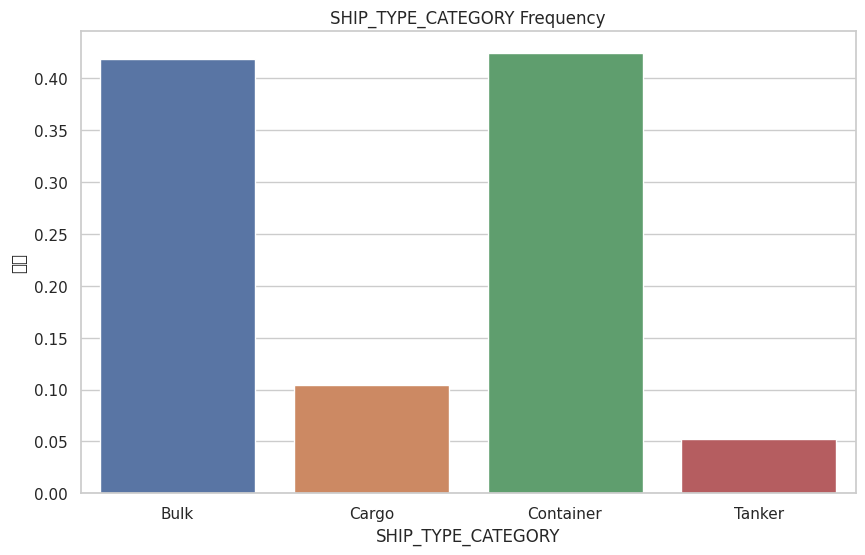

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=frequency_SHIP_TYPE_CATEGORY.index, y=frequency_SHIP_TYPE_CATEGORY.values)
plt.xlabel('SHIP_TYPE_CATEGORY')
plt.ylabel('빈도')
plt.title('SHIP_TYPE_CATEGORY Frequency')
plt.show()

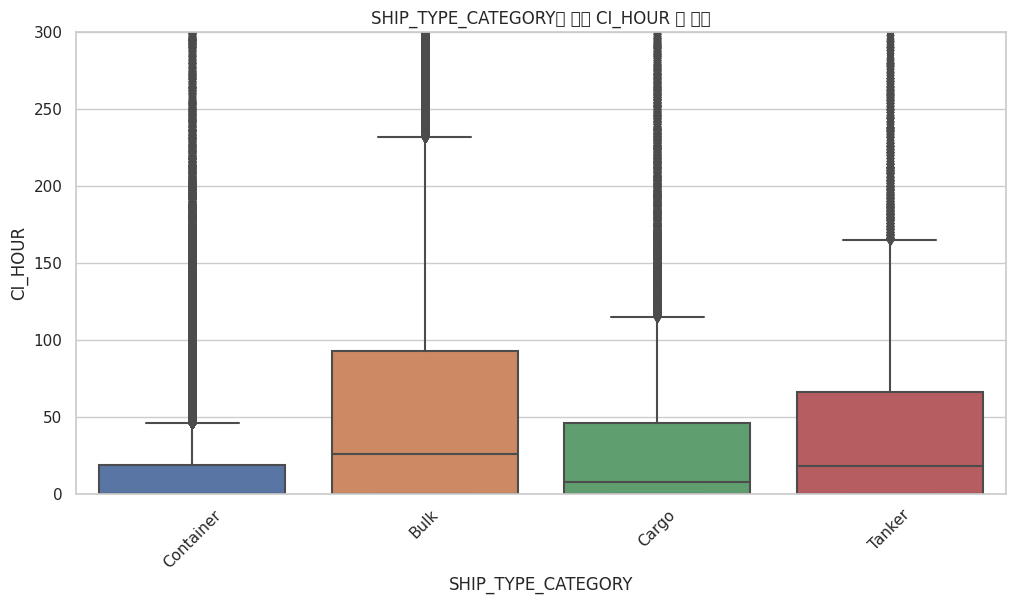

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="SHIP_TYPE_CATEGORY", y="CI_HOUR", data=train)

plt.xlabel('SHIP_TYPE_CATEGORY')
plt.ylabel('CI_HOUR')
plt.title('SHIP_TYPE_CATEGORY에 따른 CI_HOUR 값 분포')
plt.xticks(rotation=45)
plt.ylim(0, 300)
plt.show()

In [ ]:
# 예를 들어, "SHIP_TYPE_CATEGORY"가 "CategoryA"인 경우의 CI_HOUR 데이터를 가져오고 싶다고 가정
category_names = ['Container', 'Bulk', 'Cargo', 'Tanker']


for category_name in category_names:
    print(f'{category_name}')
    # 해당 카테고리의 데이터를 추출
    category_data = train[train['SHIP_TYPE_CATEGORY'] == category_name]['CI_HOUR']

    # 중앙값 (median) 찾기
    median_value = np.median(category_data)

    # 이상치 (outliers) 찾기 - 일반적으로 IQR을 사용하여 이상치를 정의합니다
    Q1 = np.percentile(category_data, 25)
    Q3 = np.percentile(category_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    outliers = [x for x in category_data if x < lower_bound or x > upper_bound]

    # 최솟값 (min) 찾기
    min_value = np.min(category_data)

    # 최댓값 (max) 찾기
    max_value = np.max(category_data)

    print(f"중앙값 (median): {median_value}")
    print(f"이상치 (outliers): {outliers}")
    print(f'이상치 개수: {len(outliers)}')
    print(f"최솟값 (min): {min_value}")
    print(f"최댓값 (max): {max_value}")
    print('----------------------------------')

Container
중앙값 (median): 0.0
이상치 (outliers): [253.5544444, 58.19305556, 271.9302778, 68.03222222, 193.9163889, 1510.709167, 157.6919444, 70.25055556, 655.0205556, 142.8144444, 82.03527778, 165.2966667, 1423.788889, 134.9844444, 151.3502778, 2119.009444, 526.4877778, 64.02861111, 996.2933333, 214.6555556, 58.13611111, 952.1522222, 63.5125, 63.81861111, 62.40166667, 119.0522222, 78.89555556, 1594.538056, 94.40305556, 585.5297222, 100.1933333, 61.58916667, 180.8425, 72.83055556, 87.05833333, 479.115, 58.04888889, 1483.549444, 541.7191667, 55.49805556, 73.16472222, 528.3688889, 1331.778056, 55.97333333, 97.96166667, 168.6836111, 93.73777778, 66.82388889, 82.44777778, 179.6625, 738.8916667, 127.1016667, 494.6919444, 64.60944444, 129.0902778, 56.98, 57.02527778, 132.075, 109.7094444, 1367.91, 1355.068889, 58.99972222, 60.99694444, 56.0325, 767.8819444, 63.91916667, 119.025, 93.37944444, 87.98861111, 102.5011111, 102.4677778, 58.87194444, 60.92, 111.305, 1386.16, 102.9083333, 99.15194444, 115.

# boruta

In [6]:
# 데이터 불러오기
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [7]:
#  1. CI_HOUR 컬럼에서 표준편차 + 2 * 표준편차 이상이 되는 부분 이상치라고 판단 후, 삭제

# 'CI_HOUR' 열의 평균과 표준 편차 계산
mean = train['CI_HOUR'].mean()
std = train['CI_HOUR'].std()

# 이상치 경계 설정 (예: 평균에서 2배 표준 편차를 벗어나는 값)
lower_bound = mean - 2 * std
upper_bound = mean + 2 * std

# 이상치를 제거하고 정상 범위의 데이터만 남김
#filtered_train = train[(train['CI_HOUR'] >= lower_bound) & (train['CI_HOUR'] <= upper_bound)]
train = train[(train['CI_HOUR'] >= lower_bound) & (train['CI_HOUR'] <= upper_bound)].reset_index(drop=True)

In [8]:
# 2. 다중공선성 문제 해결을 위해 Length 컬럼 이외 삭제 (BREADTH, DEADWEIGHT, DEPTH, DRAUGHT, GT)

for df in [train, test]:
    df.drop(columns = 'BREADTH', inplace = True)
    df.drop(columns = 'DEADWEIGHT', inplace = True)
    # df.drop(columns = 'DEPTH', inplace = True)
    df.drop(columns = 'DRAUGHT', inplace = True)
    df.drop(columns = 'GT', inplace = True)

In [9]:
'''
from sklearn.impute import KNNImputer

### 결측치 KNNImputer를 통해 대체

# K-NN 대체기
knn_imputer = KNNImputer(n_neighbors=10)

# K-NN 대체를 적용할 열을 지정
columns_to_impute = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

# train 데이터프레임에서 결측치를 K-NN으로 대체
filtered_train[columns_to_impute] = knn_imputer.fit_transform(filtered_train[columns_to_impute])

filtered_train = pd.DataFrame(filtered_train, columns=filtered_train.columns)
#filtered_train.to_csv('train_imputed.csv', index = False)

'''
# 결측치 많은 컬럼 제거
train.drop(columns = 'U_WIND', inplace = True)
train.drop(columns = 'V_WIND', inplace = True)
train.drop(columns = 'AIR_TEMPERATURE', inplace = True)
train.drop(columns = 'BN', inplace = True)

test.drop(columns = 'U_WIND', inplace = True)
test.drop(columns = 'V_WIND', inplace = True)
test.drop(columns = 'AIR_TEMPERATURE', inplace = True)
test.drop(columns = 'BN', inplace = True)


In [10]:
# 4. 결측치가 존재하는 데이터 1개 삭제
train = train.dropna(subset=['LENGTH']).reset_index(drop=True)

In [11]:
# 5. DIST가 0이면, CI_HOUR 모두 0으로 변경
train.loc[train['DIST'] == 0, 'CI_HOUR'] = 0

print(train)

       ARI_CO ARI_PO SHIP_TYPE_CATEGORY       DIST               ATA       ID  \
0          SG   GIW5          Container  30.881018  2018-12-17 21:29  Z618338   
1          IN   UJM2               Bulk   0.000000   2014-09-23 6:59  X886125   
2          CN   EUC8          Container   0.000000  2015-02-03 22:00  T674582   
3          JP   ZAG4          Container   0.000000   2020-01-17 4:02  Y847238   
4          SG   GIW5          Container  27.037650   2020-01-26 7:51  A872328   
...       ...    ...                ...        ...               ...      ...   
379811     JP   QYY1          Container   0.000000   2017-06-06 5:02  Y375615   
379812     SG   GIW5               Bulk   5.884603   2019-10-16 0:36  K635567   
379813     US   QGN3               Bulk  70.660241  2021-03-23 22:35  J284147   
379814     TW   JWI3          Container   9.448179   2015-01-08 7:15  J644215   
379815     TW   JWI3          Container   0.000000  2015-06-08 23:30  D123358   

        BUILT  DEPTH  LENGT

In [12]:
# 6. year, month, day, hour, minute, weekday 컬럼 그대로 생성
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])


# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

'''
train['CI_HOUR'] = pd.to_timedelta(train['CI_HOUR'], unit="hours")
train['Berthing datetime'] = train['ATA'] + train['CI_HOUR']
test['CI_HOUR'] = pd.to_timedelta(test['CI_HOUR'], unit="hours")
test['Berthing datetime'] = test['ATA'] + test['CI_HOUR']
'''

# 7. datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

'''# 결측치 많은 컬럼 제거
train.drop(columns = 'U_WIND', inplace = True)
train.drop(columns = 'V_WIND', inplace = True)
train.drop(columns = 'AIR_TEMPERATURE', inplace = True)
train.drop(columns = 'BN', inplace = True)

test.drop(columns = 'U_WIND', inplace = True)
test.drop(columns = 'V_WIND', inplace = True)
test.drop(columns = 'AIR_TEMPERATURE', inplace = True)
test.drop(columns = 'BN', inplace = True)'''

# 8. Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le


'''# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)
'''

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


'# 결측치 처리\ntrain.fillna(train.mean(), inplace=True)\ntest.fillna(train.mean(), inplace=True)\n'

In [13]:
# Frequency Encoding
frequency_SHIP_TYPE_CATEGORY = train.groupby("SHIP_TYPE_CATEGORY").size()/len(train)
train['frequency_SHIP_TYPE_CATEGORY'] = train['SHIP_TYPE_CATEGORY'].map(frequency_SHIP_TYPE_CATEGORY)


In [14]:
# Frequency Encoding
frequency_SHIP_TYPE_CATEGORY = test.groupby("SHIP_TYPE_CATEGORY").size()/len(test)
test['frequency_SHIP_TYPE_CATEGORY'] = test['SHIP_TYPE_CATEGORY'].map(frequency_SHIP_TYPE_CATEGORY)


In [15]:
X_train = train.drop(columns = 'CI_HOUR')
y_train = train['CI_HOUR']

X_test = test[X_train.columns]

In [16]:
!pip install boruta

In [17]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor


y_train_pd = pd.DataFrame(y_train)
y_train2 = y_train_pd.values.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestRegressor(max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter = 30)
# find all relevant features - 5 features should be selected
feat_selector.fit(np.array(X_train), y_train2)

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	9 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	10 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	11 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	12 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	13 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	14 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	15 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	16 / 30
Confirmed: 	8
Tentative: 	6
Rejected: 	5
Iteration: 	17 / 30
Confir

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=101,
                                         random_state=RandomState(MT19937) at 0x7B763E8D4040),
         max_iter=30, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B763E8D4040, verbose=2)

In [18]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  ARI_CO  - Ranking:  1
Passes the test:  ARI_PO  - Ranking:  1
Passes the test:  SHIP_TYPE_CATEGORY  - Ranking:  1
Passes the test:  DIST  - Ranking:  1
Doesn't pass the test:  ID  - Ranking:  4
Doesn't pass the test:  BUILT  - Ranking:  3
Doesn't pass the test:  DEPTH  - Ranking:  10
Doesn't pass the test:  LENGTH  - Ranking:  2
Doesn't pass the test:  SHIPMANAGER  - Ranking:  5
Doesn't pass the test:  FLAG  - Ranking:  2
Passes the test:  ATA_LT  - Ranking:  1
Passes the test:  PORT_SIZE  - Ranking:  1
Passes the test:  year  - Ranking:  1
Doesn't pass the test:  month  - Ranking:  8
Doesn't pass the test:  day  - Ranking:  9
Doesn't pass the test:  hour  - Ranking:  7
Doesn't pass the test:  minute  - Ranking:  6
Passes the test:  weekday  - Ranking:  1
Passes the test:  frequency_SHIP_TYPE_CATEGORY  - Ranking:  1


In [19]:
boruta_column_extracted = X_train.columns[feat_selector.support_]
print(boruta_column_extracted)
print(len(boruta_column_extracted))

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA_LT', 'PORT_SIZE',
       'year', 'weekday', 'frequency_SHIP_TYPE_CATEGORY'],
      dtype='object')
9


In [20]:
boruta_extracted = X_train[boruta_column_extracted]

In [21]:
# df_concat을 CSV 파일로 저장
boruta_extracted.to_csv('boruta9_extracted.csv', index=False)

In [23]:
# 데이터 불러오기
boruta_extracted = pd.read_csv("boruta9_extracted.csv")
boruta_extracted

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA_LT,PORT_SIZE,year,weekday,frequency_SHIP_TYPE_CATEGORY
0,17,21,2,30.881018,5,0.002615,2018,0,0.427597
1,7,81,0,0.000000,12,0.000217,2014,1,0.418068
2,4,14,2,0.000000,6,0.001614,2015,1,0.427597
3,8,101,2,0.000000,13,0.000356,2020,4,0.427597
4,17,21,2,27.037650,15,0.002615,2020,6,0.427597
...,...,...,...,...,...,...,...,...,...
379811,8,66,2,0.000000,14,0.000552,2017,1,0.427597
379812,17,21,0,5.884603,8,0.002615,2019,2,0.418068
379813,21,61,0,70.660241,18,0.000155,2021,1,0.418068
379814,19,35,2,9.448179,15,0.000990,2015,3,0.427597
